## ANALYZING CUSTOMER CHURN

**Project Goal:** The goal of this project is to identify key drivers of customer churn in order to make recommendations on how to minimize future churn.  We aim to create a model to identify customers at a higher risk of churn and use this to take preventative action.

Goals:
- Identify key drivers of churn
- Develop and test classification models for identifying customers at risk of churn

In [1]:
#the basics
import numpy as np
import pandas as pd

#extra math
from scipy import stats

#visualizations
import seaborn as sns
sns.set_theme() #set theme for all viz
import matplotlib.pyplot as plt

#modeling tools
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, confusion_matrix, f1_score

#My modules
import wrangle
import utils

***
## Data Acquisition
***
Data is a acquired from the telco_churn database on the codeup server


In [2]:
#Retrieve data
df = wrangle.getData('telco')

***
## Data Preparation
***
**Cleaning performed in the data preparation function**
- The only missing values were in total_charges.  
  - These were less than .2% of the entire dataset
  - The rows with these values were removed as they were such a small portion of the dataset and corresponded to brand new customers
- The total_charges column was converted to a float from a string
- The following columns were dropped:
  - payment_type_id: duplicate from sql merge
  - contract_type_id: duplicate from sql merge
  - internet_service_type_id: duplicate from sql merge
  - customer_id: primary key not useful for analysis and modeling
  - signup_date: provides similar information to the 'tenure' column
- All categorical variables were encoded
  
*Full notes on data preparation can be found in wrangle_notebook.ipynb.  Functions are stored in wrangle.py*

##### Prep the data and split into 3 subsets

In [3]:
#Prep and split the data into 70/15/15 (train/test/validate)
tr, te, val = wrangle.prep_telco(df,val_ratio=.15,test_ratio=.15)

***
## Exploration
***
*Much more exploration can be found in eda.ipynb*

In [4]:
#generate a training subset without encoded columns
tr_eda = tr.iloc[:,:20]

##### Show distribution of target variable

The churn rate is 26.59%


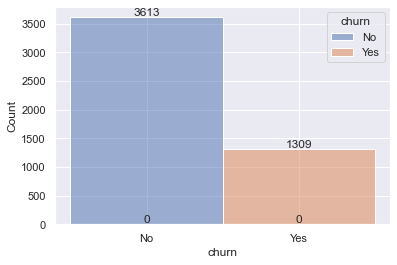

In [5]:
ax = sns.histplot(data=tr_eda,x='churn',hue='churn')
for container in ax.containers:
    ax.bar_label(container)

ch_rate = tr.has_churned.mean()
print(f'The churn rate is {(100*ch_rate):.2f}%')

### How does churn relate to customer tenure?

Text(0.5, 1.0, 'Distribution of Customer Tenure by Churn')

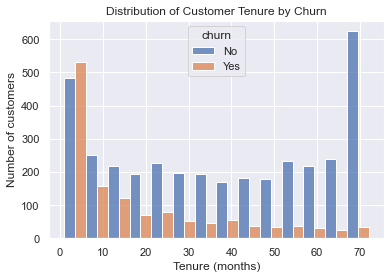

In [6]:
#Show histogram of tenure, broken out by churn
ax = sns.histplot(data=tr_eda,x='tenure',hue='churn',multiple='dodge')
ax.set_xlabel("Tenure (months)")
ax.set_ylabel("Number of customers")
ax.set_title("Distribution of Customer Tenure by Churn")

**Notes:**  We can see that the plot shows a much higher churn rate at lower tenures

### How does churn relate to monthly charges?

Those who churned have an average monthly charge of 74.96 dollars.
Those who did not churn have an average monthly charge of 61.87 dollars.


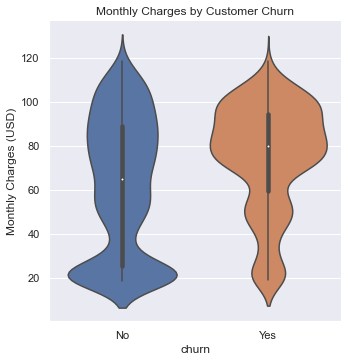

In [7]:
sns.catplot(data=tr_eda,x='churn',y='monthly_charges',kind='violin')
plt.title("Monthly Charges by Customer Churn")
plt.ylabel("Monthly Charges (USD)")

#Calculate and print average monthly charge for each churned and unchurned customers
ch_mean = tr_eda[tr_eda.churn=='Yes'].monthly_charges.mean()
st_mean = tr_eda[tr_eda.churn=='No'].monthly_charges.mean()
print(f'Those who churned have an average monthly charge of {ch_mean:.2f} dollars.')
print(f'Those who did not churn have an average monthly charge of {st_mean:.2f} dollars.')

**Notes:** This shows that those who churned on average have a higher monthly bill than those that didn't. Specifically, they paid an additional 13 dollars on average per month. It's also worth noting there is a large number of people who churned with monthly_charges between 80-100 dollars. There is also a large number of people who did not churn that had monthly charges of 20 dollars.  I dug into those customers paying < $25 in the exploratory analysis, and we see that approximately 20 percent of this dataset is customers with only phone service.

### How does churn relate to internet service type?

Text(0.5, 0, 'Internet Service Type')

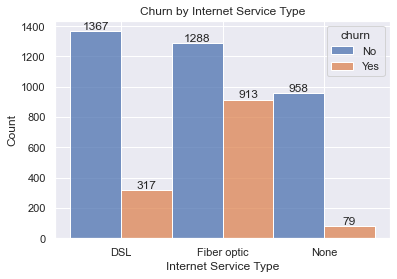

In [8]:
ax = sns.histplot(data=tr_eda,x='internet_service_type',hue='churn',multiple='dodge')
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Churn by Internet Service Type')
ax.set_xlabel('Internet Service Type')

##### Perform a chi-squared test for independence

Null Hypothesis: Internet Service Type and Churn are independent of each other.
Alternate Hypothesis: Internet Service Type and Churn are *not* independent of each other.

Use an alpha of .05

In [9]:
#set null hypothesis and alpha
null_h= f'Internet Service Type and Churn are independent of each other.'
α = .05
#create table of observed values
obs = pd.crosstab(tr_eda.internet_service_type,tr_eda.churn)
#run chi^2 test
chi2, p = stats.chi2_contingency(obs)[0:2]
#pretty print the results
utils.stats_result(p,null_h,alpha=α,chi2=chi2)


H₀: Internet Service Type and Churn are independent of each other.
We reject the null hypothesis, p = 7.906836484588637e-108 | α = 0.05
  chi2: 493.2229245606228


**Notes:**  The chart shows a much higher churn rate in fiber optic customers and a moderate churn rate in DSL customers.  With further statistical analysis, I was able to reject the null hypothesis that internet service type and churn are independent of each other.

### How does churn relate to contract type?

Text(0.5, 0, 'Contract Type')

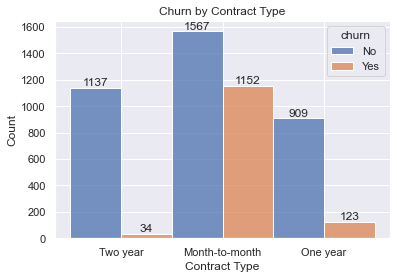

In [10]:
ax = sns.histplot(data=tr_eda,x='contract_type',hue='churn',multiple='dodge')
for container in ax.containers:
    ax.bar_label(container)
ax.set_title('Churn by Contract Type')
ax.set_xlabel('Contract Type')

##### Perform a chi-squared test for independence

Null Hypothesis: Contract Type and Churn are independent of each other.
Alternate Hypothesis: Contract Type and Churn are *not* independent of each other.

Use an alpha of .05

In [11]:
#set null hypothesis and alpha
null_h= f'Contract Type and Churn are independent of each other.'
α = .05

#create table of observed values
obs = pd.crosstab(tr_eda.contract_type,tr_eda.churn)

#run chi^2 test
chi2, p = stats.chi2_contingency(obs)[0:2]

#pretty print the results
utils.stats_result(p,null_h,alpha=α,chi2=chi2)


H₀: Contract Type and Churn are independent of each other.
We reject the null hypothesis, p = 8.258645539377003e-174 | α = 0.05
  chi2: 797.0770911703213


**Notes:**  The chart indicates a higher churn rate in month-to-month contracts. With further statistical analysis, I was able to reject the null hypothesis that contract type and churn are independent of each other.  

##### Show how contract type and internet service type relate to churn

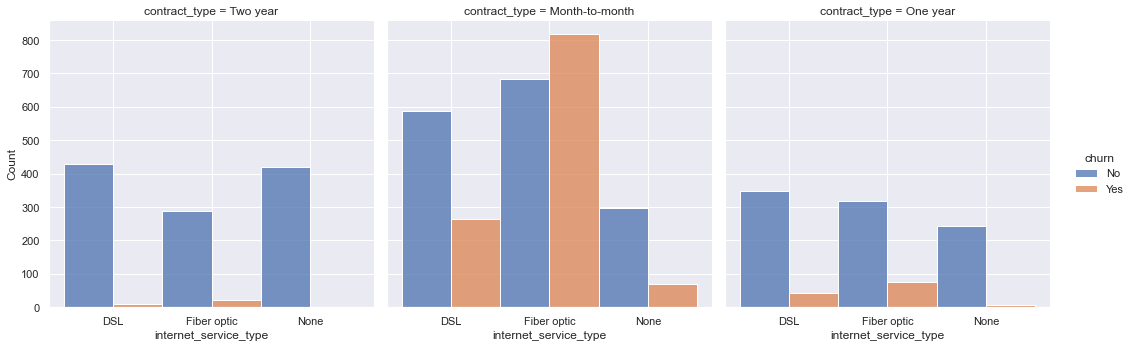

In [12]:
#internet type and contract type
sns.displot(data=tr_eda,x='internet_service_type',hue='churn',col='contract_type',multiple='dodge')

**Notes:** Previous charts showed higher churn rates in month-to-month contracts and fiber-optic and DSL customers.  Breaking this out into combined graphs we can see that the higher churn rate in DSL customers is more likely caused by the subset of DSL customers that are on month-to-month contracts as the same trend isn't visible in the other contract types.

***
## Modeling
***

##### Prepare model inputs

In [13]:
#Split subsets into encoded data and target
#Drop all object columns and has_churned
X_tr = tr.select_dtypes(exclude=object).drop(columns='has_churned')
y_tr = tr.churn

X_te = te.select_dtypes(exclude=object).drop(columns='has_churned')
y_te = te.churn

X_val = val.select_dtypes(exclude=object).drop(columns='has_churned')
y_val = val.churn

##### Classification models
- 13 models were created and ran across the train subset
  - Decision Trees with a depth of 2 through 7
  - Random Forests with a depth of 5, 10 and 15
    - The smaller depths had increased number of estimators
  - K-Nearest Neighbors with depths ranging from 3 to 10
    - A distance weight was used on depths of 3 and 5
    - A uniform weight was used on depths of 5 and 1

##### Training model evaluation
- I was most interested in accurately identifying people who will churn, therefore minimizing any false negatives.  While we want to avoid any False Positives, we can tolerate a higher number of these
   - **In the models we wanted to maximize recall, with a secondary priority of accuracy and F1 score**
   
*Knowing whether this information is used for marketing or promotional targets will sway whether we want a higher F1 score and accuracy*

#### Best performing models:
- Decision Tree with max depth of 4
- Random Forest with max depth of 10 and 150 estimators
- KNN with 5 neighbors and uniform weight

##### Generate and fit the models.  Create predictions

In [14]:
#Create results dataframe and populate with actual values
tr_res = pd.DataFrame(tr.churn)
#rename column to actual
tr_res.rename(columns={'churn':'actual'},inplace=True)

#Create model dictionary
model_dict = {}

### BASELINE ###
tr_res['baseline'] = tr.churn.mode()[0]

### DECISION TREE ###
#generate model name
model_name = 'dt_md4'

#define decision tree params
clf = DecisionTreeClassifier(max_depth=4,random_state=88)
#fit training data
clf = clf.fit(X_tr,y_tr)

#Generate train predictions and store to result dataframe
tr_res[model_name] = clf.predict(X_tr)
#Now store in our dictionary
model_dict[model_name] = {
    "model_name": model_name,
    "model":clf
}
### RANDOM FOREST ###
#generate model name
model_name = 'rf_md10_ne150'

#define decision tree params
clf = RandomForestClassifier(max_depth=10,n_estimators=150,random_state=88)
#fit training data
clf = clf.fit(X_tr,y_tr)
    
#Generate train predictions and store to result dataframe
tr_res[model_name] = clf.predict(X_tr)
#Now store in our dictionary
model_dict[model_name] = {
    "model_name": model_name,
    "model":clf
}
    
### K-NEAREST NEIGHBOR ###
#generate model name
model_name = 'knn_n5_wU'

#define decision tree params
clf = KNeighborsClassifier(n_neighbors=5,weights='uniform')
#fit training data
clf = clf.fit(X_tr,y_tr)
    
#Generate train predictions and store to result dataframe
tr_res[model_name] = clf.predict(X_tr)
#Now store in our dictionary
model_dict[model_name] = {
    "model_name": model_name,
    "model":clf
}

##### Get and print model performance metrics

In [15]:
#Postive value is churn = Yes
pos = 'Yes'

#create model performance df
mod_perf = pd.DataFrame()

#loop over columns (models)
for model_name in tr_res.columns[1:]:
    #skip actual
    if model_name=='actual': continue
    #get model stats in df and print
    df = utils.get_model_stats(tr_res.actual,tr_res[model_name],pos,to_screen=False,ret_df=True)
    #concat together
    mod_perf = pd.concat([mod_perf,df], axis=0)

mod_perf

,Accuracy,precision,recall,F1,FNR,FPR,support_pos,support_neg,TP,FP,FN,TN
baseline,0.734051,0.000000,0.000000,0.000000,1.000000,0.000000,1309,3613,0,0,1309,3613
dt_md4,0.791751,0.637864,0.501910,0.561779,0.498090,0.103238,1309,3613,657,373,652,3240
rf_md10_ne150,0.869159,0.818792,0.652406,0.726190,0.347594,0.052311,1309,3613,854,189,455,3424
knn_n5_wU,0.833401,0.745236,0.567609,0.644406,0.432391,0.070302,1309,3613,743,254,566,3359


**Notes on train predictions**:  Random Forest performed the best with a recall of .65 and an accuracy of .87.  K-Nearest neighbors came in second with a recall of .57 and a accuracy of .83.  The decision tree performed worst of these top models with a recall of .50.

##### Run models against the Validate subset

In [16]:
#create val results dataframe:  in this case, columns are models
val_res = pd.DataFrame(y_val)
val_res.rename(columns={'churn':'actual'},inplace=True)

#create new model performance dataframe
mod_perf_comp = pd.DataFrame()

#Loop over models:
for model_name in tr_res.columns[2:]:    
    #new indices to use
    ind_val = model_name + "_val"
    ind_diff = model_name + "_diff"

    #grab model from dictionary:
    clf = model_dict[model_name]['model']
    
    #generate prediction on val dataset - adds new column
    val_res[model_name] = clf.predict(X_val)
    
    #calculate val model stats - df where rows are models, stats are columns
    v_perf = utils.get_model_stats(val_res.actual,val_res[model_name],pos,to_screen=False,ret_df=True)
    #rename index to represent validate results
    v_perf.rename(index={model_name:ind_val},inplace=True)
    #add another column with difference between val and train
    v_perf.loc[ind_diff] = v_perf.loc[ind_val,'Accuracy':'FPR'] - mod_perf.loc[model_name,'Accuracy':'FPR']

    #store train, validate model stats and difference in new dataframe
    mod_perf_comp = pd.concat([mod_perf_comp,mod_perf[mod_perf.index == model_name],v_perf],axis=0)

#Print out the performance
for i in range(0,3):
    rs = i*3
    print(mod_perf_comp.iloc[rs:rs+3,0:4])
    print('\n')

             Accuracy  precision    recall        F1
dt_md4       0.791751   0.637864  0.501910  0.561779
dt_md4_val   0.796209   0.640693  0.528571  0.579256
dt_md4_diff  0.004457   0.002829  0.026662  0.017478


                    Accuracy  precision    recall        F1
rf_md10_ne150       0.869159   0.818792  0.652406  0.726190
rf_md10_ne150_val   0.799052   0.661905  0.496429  0.567347
rf_md10_ne150_diff -0.070107  -0.156887 -0.155978 -0.158844


                Accuracy  precision    recall        F1
knn_n5_wU       0.833401   0.745236  0.567609  0.644406
knn_n5_wU_val   0.750711   0.538813  0.421429  0.472946
knn_n5_wU_diff -0.082690  -0.206423 -0.146180 -0.171460




#### Model Evaluation
- The decision tree performed well against the validation subset, seeing a slight increase in recall and accuracy.
- The random forest model saw a major decrease in performance both on accuracy and recall.
- The knn did poorly on the validation set, with a significant decrease in recall. 

**The decision tree had the most consistent results across the train and validate subset and it had a better recall than the other models against the validate subset**

##### Run decision tree against test subset

In [17]:
#pull model from dictionary
clf = model_dict['dt_md4']['model']

#create test result dataframe and populate with actual values
test_res = pd.DataFrame(y_te)
test_res.rename(columns={'churn':'actual'},inplace=True)
#run against model to get predictions and probabilities
test_res['dt_md4'] = clf.predict(X_te)
test_prob = clf.predict_proba(X_te)

#print model performance to screen and store in datafram
te_perf = utils.get_model_stats(test_res.actual,test_res.dt_md4,pos,ret_df=True)

Model: dt_md4  Positive: Yes
Confusion Matrix
  TP: 147   FP: 77
  FN: 133   TN: 698
Additional Information
      Accuracy: 0.801
     Precision: 0.656
        Recall: 0.525
      F1 score: 0.583
False neg rate: 0.475
False pos rate: 0.099
 Support (pos): 280
 Support (neg): 775



**Notes:** As we can see, this model maintains a recall of over .50 and an accuracy around .80.  It has performed consistently across all slices of data

##### Generate predictions dataframe and store to csv

In [18]:
#Determine order of target variable outcomes - Second column is positive
clf.classes_

array(['No', 'Yes'], dtype=object)

In [19]:
#Create predictions dataframe
predictions = pd.DataFrame(columns=['churn_probability','churn_prediction'])

#populate churn prediction
predictions['churn_prediction'] = test_res['dt_md4']
#Add couple extra columns just to see how we did based off probability
predictions['churn_actual'] = test_res['actual']
predictions['correct_prediction'] = (predictions['churn_prediction']==predictions['churn_actual'])


#pull second column from predict_proba results 
###need to add this last, possible bug when assigning np array then pd series to a dataframe
predictions['churn_probability'] = test_prob[:,1]

#sort_values on probability for graphing
predictions.sort_values(by='churn_probability',ascending=True,inplace=True)
#generate unique id for each
predictions['id'] = range(1,len(test_res.dt_md4)+1)
#Notes:
#Customer id was dropped as the primary key as it is not valuable in EDA and modeling
# unless we want to side quest on outliers
#If we want customer id for the purposes of future modeling predictions, that would be 
# a separate (API) project at which point we can add that identifier

#Store model results against test subset into predictions.csv
sub = predictions.drop(columns=['churn_actual','correct_prediction'])
sub.to_csv('predictions.csv',index=False)

***
## Conclusion
***
##### Goals:
- Identified key drivers of churn through exploratory analysis and hypothesis testing
- Developed a model optimized to maximize recall, thereby reducing the number of customers at risk of churn that we fail to identify.

##### Key Findings
- Customers that churn have higher monthly charges on average (by 13 dollars)
- Contract type and internet service type are key drivers of churn. Statistically significant higher churn rates are found in customers:
  - On month-to-month contracts
  - With Fiber Optic internet
- Of the tested models, a decision tree with a max depth of 4 provided the most consistent results and highest recall.

##### Recommendations:
- Attempt to convert month-to-month customers to 1 and 2 year contracts
- Investigate satisfaction and availability of alternatives to fiber optic customers
- Model use cases (See chart below):
  - Target promotions with low False Positives by looking at customers with a churn probability > 70%
  - Target retention marketing with capture of False Negatives by looking at customers with a churn probability >40%

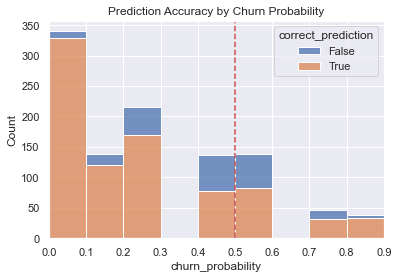

In [20]:
#Let's see how we do based on probability
ax = sns.histplot(data=predictions,x='churn_probability', binwidth=.1, binrange=[0,.9],hue='correct_prediction', multiple='stack')
#add vertical line and plot title
ax.axvline(.5,c='r',linestyle='--'); ax.set_title('Prediction Accuracy by Churn Probability')
ax.set_xticks(np.linspace(0,.9,num=10)); ax.set_xlim([0,.9]) #set x limits and ticks
plt.show()

##### Next Steps
- Perform additional modeling w/ logistic regression and adjusted hyper-parameters on random forest
- Discuss model use cases with sales and marketing
- Acquire geospatial data and availability of alternatives
  - Would greatly assist with identifying other factors of churn (or why ppl didn't churn)

***
### Appendix:
***
**Converting to 1 and 2 year contracts, isn't as simple as reducing monthly cost.**  We see in the chart below that once we filter out phone-only customers, our customers that are churning in month-to-month contracts are paying the same amount as our customers who are not churning that are on contracts.  We would have to dig in more to see if those customers who aren't churning are receiving any additional services.

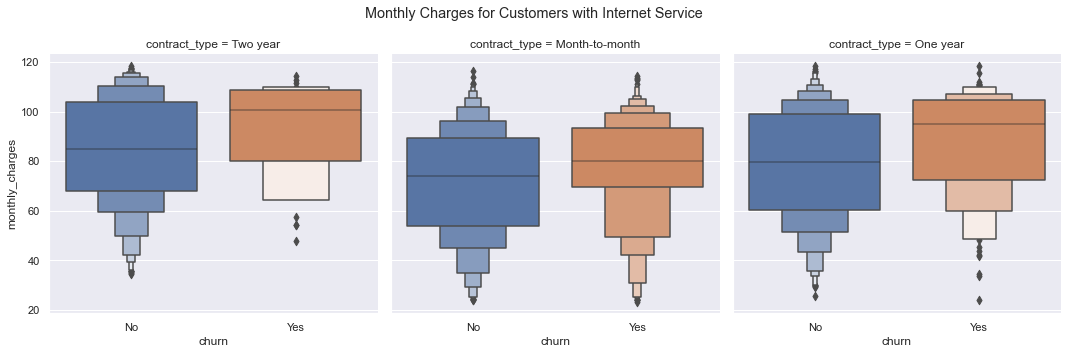

In [21]:
fg = sns.catplot(data=tr_eda[tr_eda.internet_service_type != 'None'], y='monthly_charges', x='churn',col='contract_type',kind='boxen')
fg.fig.suptitle("Monthly Charges for Customers with Internet Service")
plt.tight_layout()

**You can uncomment the below code to view functions from other modules.**

In [22]:
# import inspect
# print(inspect.getsource(utils.stats_result))
# print(inspect.getsource(utils.get_model_stats))
# print(inspect.getsource(wrangle.prep_telco))